# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import heapq
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import Counter
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

pd.set_option('display.max_colwidth', None)

# Load Data

In [2]:
## Load Data
data = pd.read_csv('Data/mtsamples.csv')

## Display information and first rows
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         4999 non-null   int64 
 1   description        4999 non-null   object
 2   medical_specialty  4999 non-null   object
 3   sample_name        4999 non-null   object
 4   transcription      4966 non-null   object
 5   keywords           3931 non-null   object
dtypes: int64(1), object(5)
memory usage: 234.5+ KB


Unnamed: 0  \
0           0   
1           1   
2           2   
3           3   
4           4   

                                                         description  \
0   A 23-year-old white female presents with complaint of allergies.   
1                           Consult for laparoscopic gastric bypass.   
2                           Consult for laparoscopic gastric bypass.   
3                                             2-D M-Mode. Doppler.     
4                                                 2-D Echocardiogram   

             medical_specialty                                sample_name  \
0         Allergy / Immunology                         Allergic Rhinitis    
1                   Bariatrics   Laparoscopic Gastric Bypass Consult - 2    
2                   Bariatrics   Laparoscopic Gastric Bypass Consult - 1    
3   Cardiovascular / Pulmonary                    2-D Echocardiogram - 1    
4   Cardiovascular / Pulmonary                    2-D Echocardiogram - 2    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [3]:
## Remove unwanted columns
data.drop(columns='Unnamed: 0', inplace=True)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   description        4999 non-null   object
 1   medical_specialty  4999 non-null   object
 2   sample_name        4999 non-null   object
 3   transcription      4966 non-null   object
 4   keywords           3931 non-null   object
dtypes: object(5)
memory usage: 195.4+ KB


# Data Dictionary

| Column            | Description                                                                               |
|-------------------|-------------------------------------------------------------------------------------------|
| description       | Contains descriptions of the medical cases. This is likely a key column for summarization. |
| medical_specialty | Indicates the medical specialty related to the note. This can be useful for filtering or categorizing summaries. |
| sample_name       | Names of the samples, which might be descriptive of the notes.                             |
| transcription     | Contains the transcribed medical notes. This will be our main text data for summarization. |
| keywords          | Lists keywords related to each transcription. This could help in understanding the context of the notes. |


# Text Preprocessing

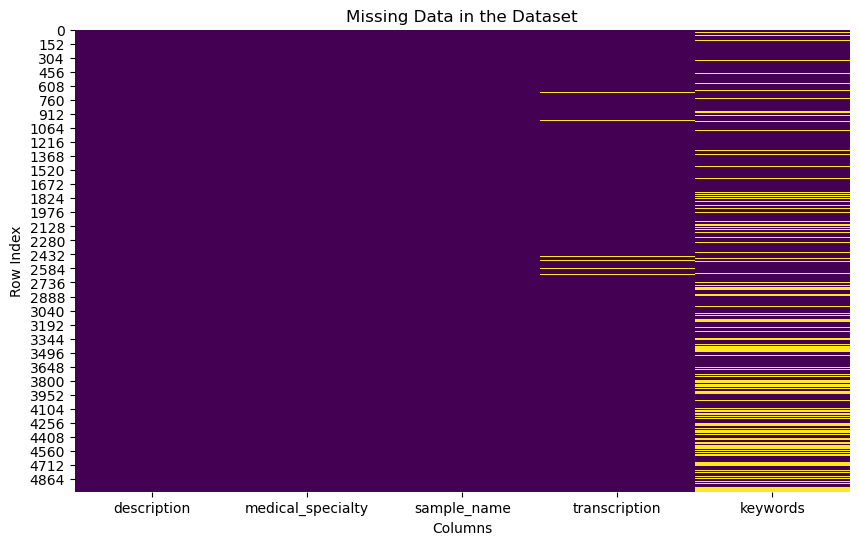

In [5]:
## Create a visualization of missing data in the transcription column
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data in the Dataset')
plt.xlabel('Columns')
plt.ylabel('Row Index')
plt.show()

In [6]:
## Drop keyword column
data.drop(columns='keywords',inplace=True)

## Remove rows with missing data from the transcription column
data.dropna(subset=['transcription'], inplace=True)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4966 entries, 0 to 4998
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   description        4966 non-null   object
 1   medical_specialty  4966 non-null   object
 2   sample_name        4966 non-null   object
 3   transcription      4966 non-null   object
dtypes: object(4)
memory usage: 194.0+ KB


In [12]:
# nltk.download('stopwords')
# nltk.download('punkt')

# def summarize_text_advanced(text):
#     stop_words = set(stopwords.words('english'))

#     # Split text into sentences
#     sentence_list = sent_tokenize(text)

#     # Create a dictionary to keep the frequency of each word
#     frequency_map = {}
#     word_list = word_tokenize(text.lower())

#     for word in word_list:
#         if word not in stop_words:
#             if word not in frequency_map:
#                 frequency_map[word] = 1
#             else:
#                 frequency_map[word] += 1

#     # Find the maximum frequency
#     max_frequency = max(frequency_map.values())

#     # Normalize the frequency by dividing by the maximum frequency
#     for word in frequency_map:
#         frequency_map[word] = frequency_map[word] / max_frequency

#     # Score sentences based on word frequencies
#     sent_scores = {}
#     for sent in sentence_list:
#         for word in word_tokenize(sent.lower()):
#             if word in frequency_map:
#                 if sent not in sent_scores:
#                     sent_scores[sent] = frequency_map[word]
#                 else:
#                     sent_scores[sent] += frequency_map[word]

#     # Select the top 10 sentences
#     summary_sentences = heapq.nlargest(10, sent_scores, key=sent_scores.get)

#     # Combine the sentences to form the summary
#     summary = ' '.join(summary_sentences)
#     return summary

# # Apply the advanced summarization function to the cleaned_transcription column
# data['summary'] = data['transcription'].apply(summarize_text_advanced)

def summarize_text_advanced(text):
    # Tokenizing the text 
    stopWords = set(stopwords.words("english")) 
    words = word_tokenize(text) 

    # Creating a frequency table to keep the  
    # score of each word 

    freqTable = dict() 
    for word in words: 
        word = word.lower() 
        if word in stopWords: 
            continue
        if word in freqTable: 
            freqTable[word] += 1
        else: 
            freqTable[word] = 1

    # Creating a dictionary to keep the score 
    # of each sentence 
    sentences = sent_tokenize(text) 
    sentenceValue = dict() 

    for sentence in sentences: 
        for word, freq in freqTable.items(): 
            if word in sentence.lower(): 
                if sentence in sentenceValue: 
                    sentenceValue[sentence] += freq 
                else: 
                    sentenceValue[sentence] = freq 

    sumValues = 0
    for sentence in sentenceValue: 
        sumValues += sentenceValue[sentence] 

    # Average value of a sentence from the original text 

    average = int(sumValues / len(sentenceValue)) 

    # Storing sentences into our summary. 
    summary = '' 
    for sentence in sentences: 
        if (sentence in sentenceValue) and (sentenceValue[sentence] > (1.2 * average)): 
            summary += " " + sentence 
    return(summary)

# Apply the advanced summarization function to the cleaned_transcription column
data['summary'] = data['transcription'].apply(summarize_text_advanced)

In [13]:
data[['transcription','summary']].head()

transcription  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     SUBJECTIVE:,  This 23-year-old white female presents with complaint of allergies.  She used to have allergies when she lived in Seattle but she thinks they are worse here.  In the past, she has tried Claritin, and Zyrtec.  Both worked for short time but then seemed to lose effectiveness.  She has used Allegra also.  She used that last summer and she began using it again two weeks ago.  It does not appear to be working very well.  She has used over-the-counter sprays but no prescription nasal sprays.  She does have asthma but doest not require daily medication for this and does not think it is flaring up.,MEDICATIONS: , Her only medication currently is Ortho Tri-Cyclen and the Allegra.,ALLERGIES: , She has no known medicine allergies.,OBJECTIVE:,Vitals:  Weight was 130 pounds and blood pressure 124/78.,HEENT:  Her throat was mildly erythematous without exudate.  Nasal mucosa wa

In [16]:
# Calculate the lengths of the 'cleaned_transcription' and 'summary' columns for the first 10 rows
data['transcription_length'] = data['transcription'].apply(len)
data['summary_length'] = data['summary'].apply(len)

# Select the first 10 rows and the relevant columns
comparison_df = data[['transcription', 'summary', 'transcription_length',
                      'summary_length']]
comparison_df.info()
comparison_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4966 entries, 0 to 4998
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   transcription         4966 non-null   object
 1   summary               4966 non-null   object
 2   transcription_length  4966 non-null   int64 
 3   summary_length        4966 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 194.0+ KB


transcription  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     SUBJECTIVE:,  This 23-year-old white female presents with complaint of allergies.  She used to have allergies when she lived in Seattle but she thinks they are worse here.  In the past, she has tried Claritin, and Zyrtec.  Both worked for short time but then seemed to lose effectiveness.  She has used Allegra also.  She used that last summer and she began using it again two weeks ago.  It does not appear to be working very well.  She has used over-the-counter sprays but no prescription nasal sprays.  She does have asthma but doest not require daily medication for this and does not think it is flaring up.,MEDICATIONS: , Her only medication currently is Ortho Tri-Cyclen and the Allegra.,ALLERGIES: , She has no known medicine allergies.,OBJECTIVE:,Vitals:  Weight was 130 pounds and blood pressure 124/78.,HEENT:  Her throat was mildly erythematous without exudate.  Nasal mucosa wa

In [22]:
## Function to remove special characters, numbers, stop words
# nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    ## Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    ## Convert to lowercase
    text = text.lower()
    
    ## Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

## Apply preprocessing to the transcription and summary columns separately
data['cleaned_transcription'] = data['transcription'].apply(preprocess_text)
data['clean_summary'] = data['summary'].apply(preprocess_text)

## Save as .csv file
data.to_csv('Data/clean_data.csv')

## Display the first few rows of the cleaned data
data.head()

description  \
0   A 23-year-old white female presents with complaint of allergies.   
1                           Consult for laparoscopic gastric bypass.   
2                           Consult for laparoscopic gastric bypass.   
3                                             2-D M-Mode. Doppler.     
4                                                 2-D Echocardiogram   

             medical_specialty                                sample_name  \
0         Allergy / Immunology                         Allergic Rhinitis    
1                   Bariatrics   Laparoscopic Gastric Bypass Consult - 2    
2                   Bariatrics   Laparoscopic Gastric Bypass Consult - 1    
3   Cardiovascular / Pulmonary                    2-D Echocardiogram - 1    
4   Cardiovascular / Pulmonary                    2-D Echocardiogram - 2    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [24]:
## Train test split
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

## Check shape of train and testing data
print(train_data.shape)
test_data.shape

(3972, 10)


(994, 10)

In [25]:
## Tokenization
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(train_data['cleaned_transcription'])
word_index = tokenizer.word_index

## Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(train_data['cleaned_transcription'])
test_sequences = tokenizer.texts_to_sequences(test_data['cleaned_transcription'])

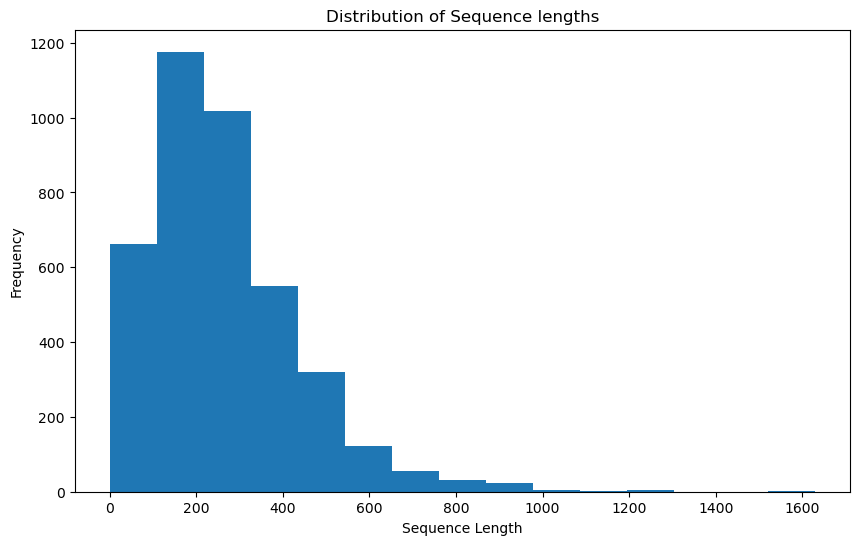

In [26]:
## Visualize sequence lengths

## Calculate length of the sequences
sequence_lengths = [len(seq) for seq in train_sequences]

## Plot distribution of the lengths
plt.figure(figsize=(10,6))
plt.hist(sequence_lengths, bins=15)
plt.title('Distribution of Sequence lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

In [27]:
## Descriptive statistics
max_seq_length = max(sequence_lengths)
mean_seq_length = sum(sequence_lengths) / len(sequence_lengths)
percent_90 = sorted(sequence_lengths)[int(len(sequence_lengths) * 0.9)]

print(f"Max sequence length: {max_seq_length}")
print(f"Mean sequence length: {mean_seq_length}")
print(f"90th percentile sequence length: {percent_90}")

Max sequence length: 1628
Mean sequence length: 263.31545820745214
90th percentile sequence length: 486


In [42]:
## Padding sequences
max_length = 500
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post',
                            truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post',
                           truncating='post')
train_padded[:5]

array([[   60,   110,   456, ...,     0,     0,     0],
       [  477,   367,   132, ...,   274,  2041,   432],
       [   60,   110,  6654, ...,     0,     0,     0],
       [   90,  1606, 29613, ...,     0,     0,     0],
       [   60,    24,     4, ...,     0,     0,     0]])

In [43]:
# Tokenization and padding for summaries (targets)
tokenizer.fit_on_texts(train_data['summary'])
train_summary_sequences = tokenizer.texts_to_sequences(train_data['summary'])
test_summary_sequences = tokenizer.texts_to_sequences(test_data['summary'])

# Padding sequences
max_summary_length = 50  # Adjust this value based on the data
train_summary_padded = pad_sequences(train_summary_sequences, maxlen=max_summary_length, padding='post', truncating='post')
test_summary_padded = pad_sequences(test_summary_sequences, maxlen=max_summary_length, padding='post', truncating='post')

# Prepare decoder input and output (shifted by one position)
decoder_input_data = train_summary_padded[:, :-1]
decoder_output_data = train_summary_padded[:, 1:]

# Expand dimensions to match the required shape
decoder_output_data = np.expand_dims(decoder_output_data, -1)

# Define the model architecture
vocab_size = len(word_index) + 1
embedding_dim = 100
latent_dim = 256

# Encoder
encoder_inputs = Input(shape=(max_length,))
encoder_embedding = Embedding(vocab_size, embedding_dim, input_length=max_length)(encoder_inputs)
encoder_lstm, state_h, state_c = LSTM(latent_dim, return_state=True)(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_summary_length - 1,))
decoder_embedding = Embedding(vocab_size, embedding_dim, input_length=max_summary_length - 1)(decoder_inputs)
decoder_lstm, _, _ = LSTM(latent_dim, return_sequences=True, return_state=True)(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(vocab_size, activation='softmax')(decoder_lstm)

# Model
model = Model([encoder_inputs, decoder_inputs], decoder_dense)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
model.summary()

# Train the model
history = model.fit(
    [train_padded, decoder_input_data],
    decoder_output_data,
    epochs=5,  # Adjust epochs as needed
    validation_split=0.2
)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 49)]         0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 500, 100)     3586600     ['input_9[0][0]']                
                                                                                                  
 embedding_9 (Embedding)        (None, 49, 100)      3586600     ['input_10[0][0]']               
                                                                                            

In [ ]:
count vectorizer
tf-idf

In [ ]:
umap learn library
word cloud
word frequency
bigram, trigram
spacy for NER
sentiment: vader sentiment
what is exploratory for words